In [110]:
# Script for Bayesian Parametric Inference with Probabilistic Machine Learning Package PYMC
# Example Data: Annual Maximum Series (AMS) fitted to  Generalized Extreme Value Distribution, source:Coles(2001)
# Dawar Qureshi (October, 2021)
# the author can be reached at https://www.linkedin.com/in/dawar-qureshi-7284b089/ for 
# more sophisticated data visualisation techniques and general queries 

In [111]:
# imports necessary to carry out the analysis
import aesara.tensor as at
import arviz as az 
import matplotlib.pyplot as plt
import numpy as np 
from arviz.plots import plot_utils as azpu 
import scipy.stats as stats 
from scipy.stats import genextreme 
import bokeh  
import seaborn as sns 
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.1.4


In [112]:
# Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy
# ArviZ is a Python package for exploratory analysis of Bayesian models.
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices.
# SciPy is a free and open-source Python library used for scientific computing and technical computing. 
# a Python library for creating interactive beautiful visualizations for modern web browsers. 
# Seaborn is a library for making statistical graphics in Python
# Aesara is a Python library for defining, optimizing, and efficiently evaluating mathematical expressions involving multi-dimensional arrays.

# Bayesian Inference

Bayesian statistics employs probabilistic assertions to draw conclusions about a parameter vector θ or an unobserved data set ẑ. These probabilistic statements are conditional on the observed value of data vector z = (z1, z2,...,zn) and are written as π (θ|z) or π (ẑ|z). Prior to examining the data, the assumptions about θ are recorded, in the form of prior probability distribution π (θ). A joint probability distribution function for θ and ẑ is written as a product of prior distribution π (θ) and likelihood function π (z|θ) to make probabilistic statements. To yield the posterior probability, Bayes’ theorem combines the prior probability and the likelihood function as:

\begin{align}
\pi(θ|z) = \frac{\pi(θ)\pi(z|θ)}{\pi(z)}\\
\end{align}
                             
The denominator in this equation is the normalization constant which makes sure that the posterior distribution on the left side of the equation is a valid probability density and integrates to one. The marginal distribution does not depend on the parameters for which one want to make inference as these parameters have been integrated out, which makes it difficult to calculate the integral in closed form. Therefore, the equation is generally written in the form:
\begin{align}
\pi(θ|z)∝\pi(θ)\pi(z|θ)\\
\end{align}

or in words:
\begin{align}
Posterior ∝ Likelihood × Prior \\
\end{align}

# Generalized Extreme Value Distribution (GEV)

The Generalized Extreme Value Distribution (Gev) is a meta-distribution which includes the Weibull, Gumbel, and Frechet families of extreme value distributions. It is used to model the distribution of extremes (maxima or minima) of stationary processes, such as the annual maximum wind speed,annual maximum rainfall, annual maximum truck weight on a bridge, and so on, without requiring an a priori decision on the tail behavior. If the annual maximum   rainfall   values are represented by x1, x2...xn, which are considered independent variables,

The GEV distribution for a maxima is given by[Coles 2001]:

\begin{align}
G(x) = exp{-[1 + \frac{ξ(x-μ)} {σ}] ^ \frac{-1}{ξ}}\\
\end{align}


                        
                                 
when:

ξ < 0, we get the Weibull distribution with a bounded upper tail;

ξ = 0, in the limit, we get the Gumbel distribution, unbonded in both tails;

ξ > 0 , we get the Frechet distribution which is bounded in the lower tail.

Note that the sign of the shape parameter is opposite to the sign used in SciPy's stats.genextreme function


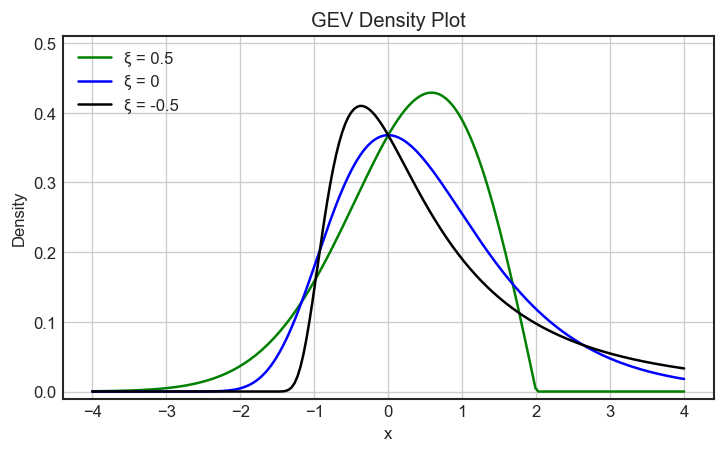

In [45]:
# Density plot of GEV distribution for different values of shape parameter
plt.figure(1,figsize= [7,4], dpi = 120)
x = np.linspace(-4, 4, 200)
plt.plot(x, genextreme.pdf(x, 0.5), color='green', label='ξ = 0.5')
plt.plot(x, genextreme.pdf(x, 0.0), 'blue', label='ξ = 0')
plt.plot(x, genextreme.pdf(x, -0.5), 'black', label='ξ = -0.5')
plt.ylim(-0.01, 0.51)
plt.legend(loc='upper left')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('GEV Density Plot')
plt.grid('on')
plt.show()

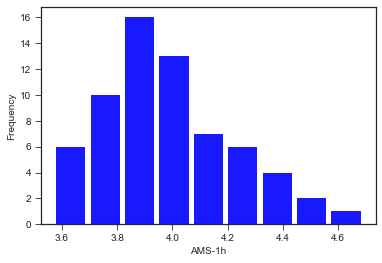

In [46]:
# Load the data 
plt.style.use('seaborn-ticks')
data = np.array([4.03, 3.83, 3.65, 3.88, 4.01, 4.08, 4.18, 3.80, 
                 4.36, 3.96, 3.98, 4.69, 3.85, 3.96, 3.85, 3.93, 
                 3.75, 3.63, 3.57, 4.25, 3.97, 4.05, 4.24, 4.22, 
                 3.73, 4.37, 4.06, 3.71, 3.96, 4.06, 4.55, 3.79, 
                 3.89, 4.11, 3.85, 3.86, 3.86, 4.21, 4.01, 4.11, 
                 4.24, 3.96, 4.21, 3.74, 3.85, 3.88, 3.66, 4.11, 
                 3.71, 4.18, 3.90, 3.78, 3.91, 3.72, 4.00, 3.66, 
                 3.62, 4.33, 4.55, 3.75, 4.08, 3.90, 3.88, 3.94, 
                 4.33])

plt.hist(data,bins='auto', color='blue', alpha=0.9, rwidth=0.85)
plt.xlabel("AMS-1h")
plt.ylabel("Frequency")
plt.show()

In [47]:
# Alternatively we could use bokeh to get interactive plots
from bokeh.io import show, output_file
from bokeh.plotting import figure

hist, edges = np.histogram(data, density=True, bins=50)

p = figure()
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="white")

output_file("hist.html")
show(p)

# Modellling


We wish to make a parametric inference on GEV parameters based on some farily non-informative priors to reflect our ignorance about the processes which generated the data set and also to do predictive analysis of return level estimates for different return periods.

Selection of Priors:


μ : there is no real basis for considering anything other than a Normal distribution with a standard deviation limiting negative outcomes;

σ : this must be positive, therefore we can select a Normal distribution with a large variance;

ξ : we are agnostic to the tail behaviour so we can use a Normal Distribution centered at zero, or in other cases limit to physically reasonable bounds by using a HalfNormal distribution. 

As the Generalized Extreme Value distribution is not included in the set of continuous distributions in PYMC, we define the custom distribution, which is the log likelihood of the cdf of GEV.


In [48]:
def gev_logp(data,μ  ,  σ,  ξ):
        scaled = (data - μ ) /  σ
        logp_xi_not_zero = -(at.log( σ)
                 + (( ξ + 1) /  ξ) * at.log1p( ξ * scaled)
                 + (1 +  ξ * scaled) ** (-1/ ξ))
        logp_xi_zero = -at.log( σ) + ( ξ+1)*(-(data - μ )/ σ) - at.exp(-(data - μ )/ σ)
        logp = at.switch(at.abs_( ξ) > 1e-4  , logp_xi_not_zero, logp_xi_zero) 
        return at.sum(logp)

with pm.Model() as model:
    μ = pm.Normal("μ", mu=1, sigma=100)
    σ= pm.Normal("σ",mu=1, sigma=100)
    ξ = pm.TruncatedNormal("ξ", mu=0, sigma=0.2, lower=-0.6, upper=0.6)
    #ξ= pm.Beta("ξ",alpha=6, beta=9)
   
    gev = pm.DensityDist( "gev", μ, σ, ξ, logp= gev_logp, observed = data)
    
   
    

# Inference

Pressing the magic inference button

In [49]:
with model:
    idata = pm.sample(
        5000,
        cores=4,
        chains=4,
        tune=2000,
        initvals={"μ": -0.5, "σ": 1.0, "ξ": -0.1},
        target_accept=0.999,
    )
   

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 65 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


# Divergences

The trace exhibits divergences (usually). The HMC/NUTS sampler can have problems when the bounds of support for parameters are approached. And since the bounds of the GEV change with the sign of 
ξ , it is difficult to offer a transformation that resolves this problem. One possible transformation - the Box-Cox - has been proposed by Bali [2003], but Caprani and OBrien [2010] find it numerically unstable, even for just maximum likelihood estimation. In any case, recommendations to alleviate divergence problems are:


Increase the target acceptance ratio;

Use more informative priors, especially limit the shape parameter to physically reasonable values, typically 
ξ ∈ [−0.5,0.5];

Decide upon the domain of attraction of the tail (i.e. Weibull, Gumbel, or Frechet), and use that distribution directly.

# Inference Results

The 95% credible interval range of the parameter estimates is:
    

In [50]:
az.hdi(idata, hdi_prob=0.95)

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    μ        (hdi) float64 3.817 3.927
    σ        (hdi) float64 0.1653 0.2475
    ξ        (hdi) float64 -0.1997 0.1469

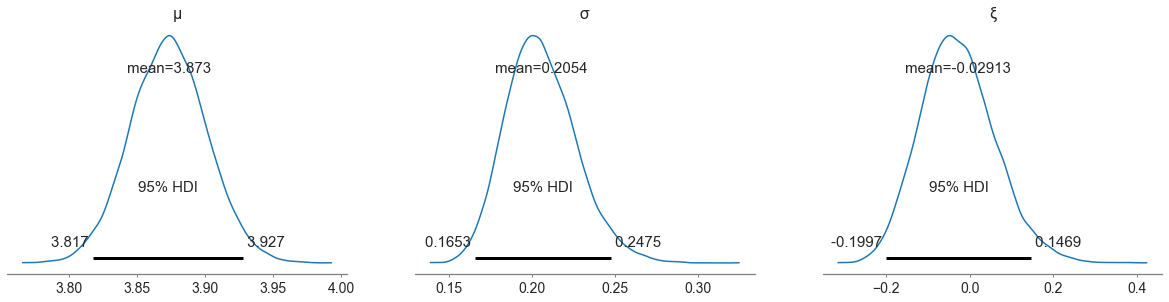

In [51]:
# The Posterior distribution of parameter set
az.plot_posterior(idata, hdi_prob=0.95, var_names=["μ", "σ", "ξ"], round_to=4,);

# Comparison

To compare with the results , we approximate the maximum likelihood estimates (MLE) using the median of the posterior distributions (the maximum a posteriori or MAP estimate). These are close when the prior is reasonably flat around the posterior estimate.

In [52]:
_, vals = az.sel_utils.xarray_to_ndarray(idata["posterior"], var_names=["μ", "σ", "ξ"])
mle = [azpu.calculate_point_estimate("median", val) for val in vals]
mle

[3.8729764320626807, 0.20384745943064905, -0.034062015758864694]

In [53]:
# Maximum Likelihood Values could also be computed with scipystats
# Caution: the shape parameter in scipystats follow opposite sign convention compared to Coles(2001)
shape1, loc1, scale1 =stats.genextreme.fit(data)
print(shape1, loc1, scale1)


0.05010534785328627 3.874758730628963 0.19803814023673208


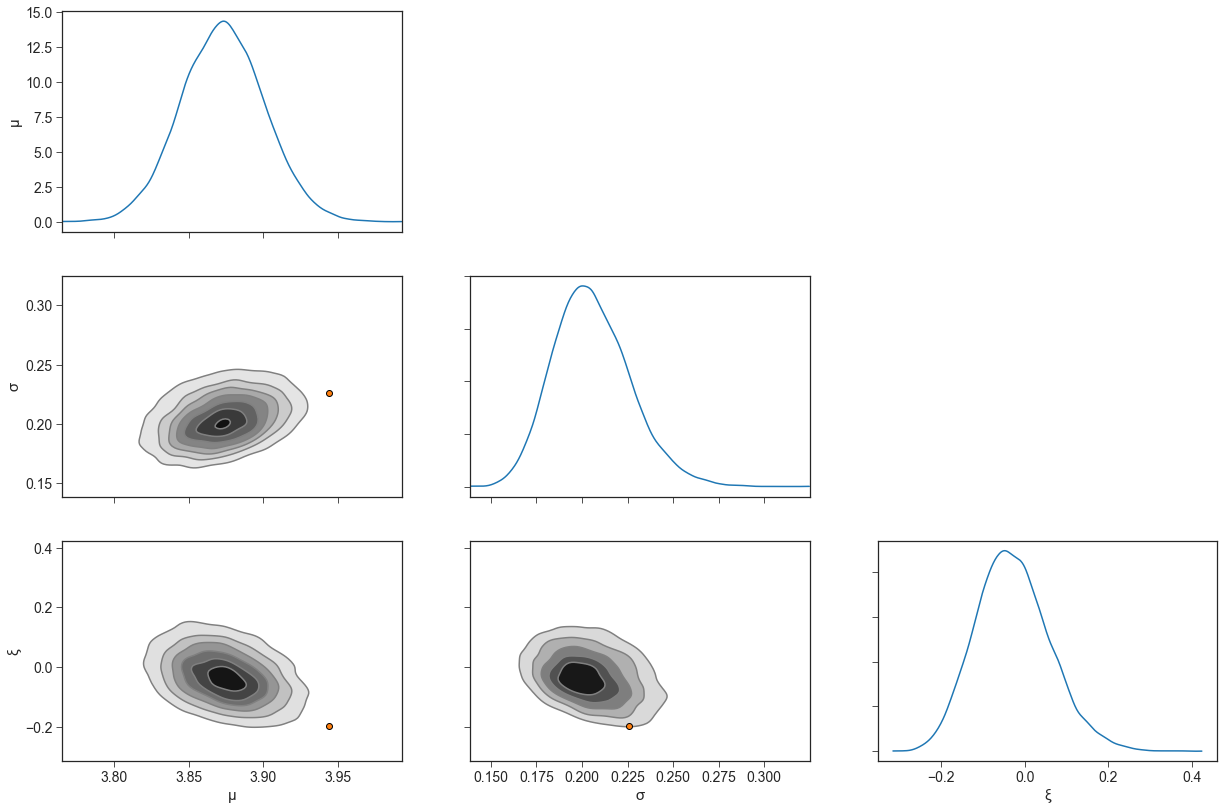

In [54]:
# The relation between the parameters can be visually inspected with a pair plot
az.plot_pair(idata, var_names=["μ", "σ", "ξ"], kind="kde", marginals=True, divergences=True);

In [55]:
# The values from the 4 chains used in this analysis are stacked by the following function:
stacked = idata.posterior.stack(draws=("chain", "draw"))

# Predictive Distribution

The Bayesian predictive distribution of return levels obtained by considering 5000 samples (or as desired) from the posterior distributions of the three GEV parameters using SciPy’s genextreme.rvs function in the Python programming language. The equivalent return level distribution simulated using MLE best guess estimates is also derived to presenta comparative overview. 

In [56]:
sample_number = 5000
shape_posterior = stacked.ξ.values[0:5000]
loc_posterior= stacked.μ.values[0:5000]
scale_posterior = stacked.σ.values[0:5000]

In [57]:
#Generate the Predictive Distribution for return levels
p_bayes = np.zeros(sample_number)


for i in range(sample_number):   
    
    p_bayes[i]=genextreme.rvs(c=-1*shape_posterior[i],loc=loc_posterior[i], scale=scale_posterior[i], size =1)

(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        4.000e+00, 1.700e+01, 6.000e+00, 1.700e+01, 3.100e+01, 3.400e+01,
        7.000e+01, 8.500e+01, 1.130e+02, 1.620e+02, 1.690e+02, 2.320e+02,
        3.250e+02, 3.820e+02, 4.710e+02, 5.000e+02, 6.120e+02, 7.720e+02,
        8.850e+02, 1.006e+03, 1.123e+03, 1.231e+03, 1.364e+03, 1.436e+03,
        1.602e+03, 1.788e+03, 1.936e+03, 1.929e+03, 2.055e+03, 2.118e+03,
        2.216e+03, 2.266e+03, 2.246e+03, 2.356e+03, 2.424e+03, 2.380e+03,
        2.378e+03, 2.512e+03, 2.433e+03, 2.336e+03, 2.394e+03, 2.328e+03,
        2.228e+03, 2.280e+03, 2.216e+03, 2.137e+03, 2.052e+03, 1.919e+03,
        1.999e+03, 1.864e+03, 1.897e+03, 1.750e+03, 1.612e+03, 1.599e+03,
        1.471e+03, 1.413e+03, 1.423e+03, 1.319e+03, 1.232e+03, 1.144e+03,
        1.125e+03, 1.091e+03, 1.040e+03, 9.830e+02, 8.530e+02, 8.200e+02,
        7.720e+02, 7.550e+02, 6.940e+02, 6.230e+02, 6.000e+02, 5.510e+02,
        5.390e+02, 4.700e+02, 4.690e+0

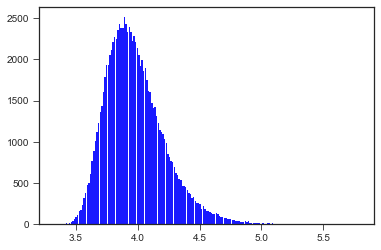

In [76]:
# Generate the equivalent prediction for MLE point estimates calculated earlier
q_mle =  genextreme.rvs(c= shape1,loc=loc1, scale=scale1, size=100000)
plt.hist(q_mle, bins='auto', color='blue', alpha=0.9,rwidth=0.9 )

# Return Levels

The percentile values 50, 80, 90, 96, 98, 99, 99.9 corresponding to the return periods 2-, 5-, 10-, 25-, 50-, 100-, 1000- year respectively can be used to obtain the return levels or rainfall depths


In [84]:
#Calculate return levels with numpys percentile function

np.percentile(q_mle, 99.9)


5.047309251201425

In [85]:
np.percentile(p_bayes, 99.9)

5.261625872941949

In [ ]:
sns.set_style("white")
a = sns.distplot(q_mle1, hist=False, color='dimgrey',kde_kws = {'shade': False, 'linewidth': 1}, ax=ax1)
a = sns.distplot(p_bayes1, hist=False, color='deepskyblue',kde_kws = {'shade': False, 'linewidth': 1}, ax=ax1)

custom_title2 = '24-h duration'
custom_xlim1=(-2,100)
custom_xlim2=(-1,100)
plt.setp(ax1, xlim=custom_xlim1, title=custom_title1)
plt.setp(ax2, xlim=custom_xlim2, title=custom_title2)
a.set(xlabel='Return level (mm)', ylabel='Probability Density')
b.set(xlabel='Return level (mm)', ylabel='Probability Density')
plt.savefig('densityplot.png')
b.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

(3.0, 5.0)

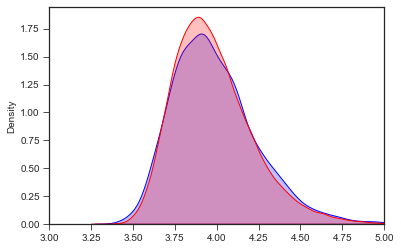

In [101]:
a = sns.kdeplot(np.array(p_bayes), color= "b", fill= True)
a = sns.kdeplot(np.array(q_mle),color= "r", fill= True, )
a.set_xlim(3,5)

# References

Stuart Coles. An introduction to statistical modeling of extreme values. Springer Series in Statistics. Springer, London, England, 2001 edition, August 2001. ISBN 978-1-85233-459-8. URL: https://doi.org/10.1007/978-1-4471-3675-0.